# Real data

In [1]:
import os; from os import listdir; from os.path import isfile, join
import re  
#from skimage import io 
from skimage.io import imread
# To manipulate arrays
import numpy as np 
import random
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import sys
import rsnapsim as rss

from skimage.exposure import rescale_intensity
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
# To create interactive elements
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image
import dna_features_viewer
from dna_features_viewer import BiopythonTranslator, GraphicFeature, GraphicRecord, CircularGraphicRecord

# Deffining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
#video_dir = current_dir.parents[1].joinpath('DataBases','LargeDataSets','20190909_u2os_multiplex','smFLAG-KDM5B')
video_dir = current_dir.parents[1].joinpath('DataBases','LargeDataSets','20190909_u2os_multiplex','smFLAG-ActB')

rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')

# Importing rSNAPsim_IP
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp


In [2]:
#Function to detect all tif files in a folder
def folder_reader(folder):
    '''
    This function imports all tif files in a give folder.
    Input:
    folder: str, with the file name.

    Returns:
    list_files_names :  List of str with all file names
    path_files : List of str with all file paths
    '''
    # Reads the folder with the results and import the simulations as lists
    list_files_names = sorted([f for f in listdir(folder) if isfile(join(folder, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
    list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
    path_files = [ str(folder.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
    # Reading the microscopy data
    max_frames_to_read = 100
    list_videos = [imread(f)[0:max_frames_to_read,:,:,:] for f in  path_files] # List with all the videos. 
    num_videos = len(path_files) # the number of videos in the folder is the length of list_videos
    return path_files, list_files_names,list_videos, num_videos

In [3]:
# Load gene sequences
path_files,list_files_names,list_videos, num_videos = folder_reader(video_dir)
print(path_files)

['/home/luisub/Desktop/rsnaped/DataBases/LargeDataSets/20190909_u2os_multiplex/smFLAG-ActB/MAX_Cell01.tif', '/home/luisub/Desktop/rsnaped/DataBases/LargeDataSets/20190909_u2os_multiplex/smFLAG-ActB/MAX_Cell02.tif']


In [4]:
# Coding sequence
gene_file = str(sequences_dir.joinpath('Bactin_withTags.txt')) # coding sequence for SM_KDM5B_PP7    ### 5685 nt   ### 1895 codons
#gene_file= str(sequences_dir.joinpath('KDM5B_withTags.txt'))  # coding sequence for SM_p300_MS2      ### 8268 nt   ### 2756 codons

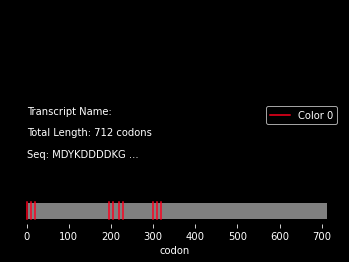

In [5]:
# Simulating a TASEP model for the beta-actin gene
poi_strs, poi_objs, tagged_pois,raw_seq = rss.seqmanip.open_seq_file(gene_file)  #open this file and find all valid protein of interest objs
gene_mrna = tagged_pois['1'][0]  #lets take the first one since thats the longest
rss.solver.protein = gene_mrna #pass this protein object to the solver
gene_mrna.visualize_probe()  # what does our construct look like?

In [6]:
intensity_calculation_method = 'disk_donut'  # options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'
mask_selection_method = 'max_area' # options are : 'max_spots' and 'max_area' 
use_optimization_for_tracking = 0 # 0 not using, 1 is using optimization
#frame_selection_empty_video = 'constant' # Options are: 'constant' , 'shuffle' and 'loop'
#particle_size = 3 # spot size for the simulation and tracking.
particle_detection_size = 5 # spot size for the simulation and tracking.

In [7]:
def plot_original_images(image,slice=0):
    '''
    This function plots all the channels for the original image.
    '''
    number_channels = image.shape[3]
    fig, axes = plt.subplots(nrows=1, ncols=number_channels, figsize=(15, 5))
    for i in range (0,number_channels ):
        img_2d = image[slice,:,:,i]
        img_2d_rescaled = rsp.RemoveExtrema(img_2d, min_percentile = 0.5, max_percentile= 99.5, selected_channels=[0,1]).remove_outliers()
        axes[i].imshow(img_2d_rescaled, cmap='viridis') 
        axes[i].set_title('Channel_'+str(i))
    plt.show()

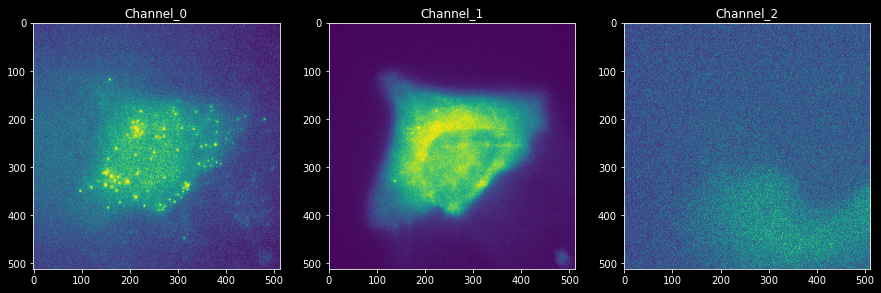

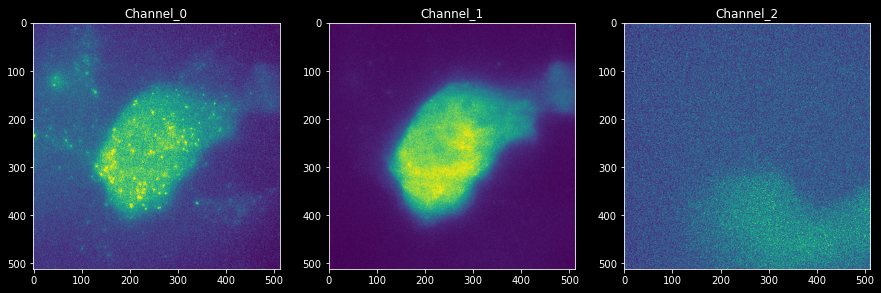

In [8]:
plot_original_images(list_videos[0])
plot_original_images(list_videos[1])

mask time: 6  sec
tracking time: 7  sec
intensity calculation time: 30  sec


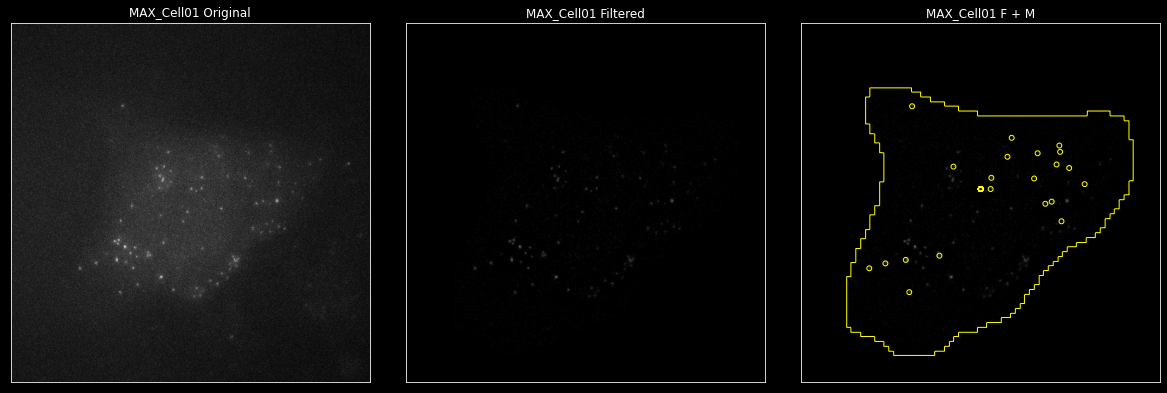

mask time: 4  sec
tracking time: 4  sec
intensity calculation time: 12  sec


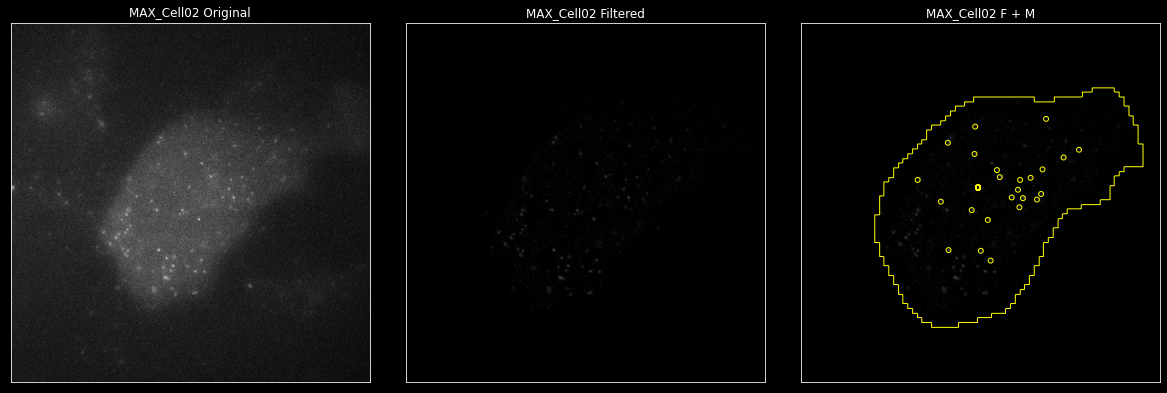

In [9]:
list_DataFrame_particles_intensities= []
for i, temp_video in enumerate(list_videos):
    DataFrame_particles_intensities, _, _, _,_, _, _ = rsp.PipelineTracking(temp_video,particle_size=particle_detection_size,file_name=list_files_names[i],selected_channel=0,intensity_calculation_method =intensity_calculation_method, mask_selection_method = mask_selection_method,show_plot=1,use_optimization_for_tracking=use_optimization_for_tracking,real_positions_dataframe = None, average_cell_diameter=200, print_process_times=1).run()    
    list_DataFrame_particles_intensities.append(DataFrame_particles_intensities)

In [10]:
df =list_DataFrame_particles_intensities[1]
df

,cell_number,particle,frame,red_int_mean,green_int_mean,blue_int_mean,red_int_std,green_int_std,blue_int_std,x,y,SNR_red,SNR_green,SNR_blue,background_int_mean_red,background_int_mean_green,background_int_mean_blue,background_int_std_red,background_int_std_green,background_int_std_blue
0,0,0,0,223.839996,0.000000,0.00,238.005492,200.806175,23.328815,266.919099,280.003677,16.632925,14.379186,15.543833,945.410706,3083.339355,572.214294,69.370842,213.183136,35.957668
1,0,0,1,222.839996,6.420000,4.20,174.903329,205.439805,24.316250,266.225774,279.127347,17.251110,12.504579,18.780113,958.732117,3194.089355,567.839294,67.522614,254.540359,30.202162
2,0,0,2,224.500000,0.000000,3.86,187.411419,182.292407,20.031735,265.324966,279.735724,15.108646,11.840131,17.519183,931.571411,3152.714355,559.178589,75.387299,264.331543,31.700108
3,0,0,3,245.419998,0.000000,11.16,247.682203,244.212367,35.939594,266.718227,279.115142,14.419894,12.416456,26.354729,968.839294,3254.946533,565.410706,83.836952,257.335907,21.823788
4,0,0,4,229.479996,118.959999,0.00,221.225879,211.085287,26.401636,266.042735,279.272580,15.041061,12.142325,18.141393,948.678589,3208.125000,572.571411,76.821709,271.279175,31.175114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3148,0,54,95,25.139999,0.000000,12.60,78.883651,317.335573,46.618451,195.108218,362.820023,15.870336,11.264014,16.916507,910.446411,3404.625000,586.928589,58.640221,295.976196,35.149101
3149,0,54,96,0.000000,0.000000,10.32,55.360260,304.472617,43.076416,197.087966,361.224191,14.615074,13.214333,12.925952,911.750000,3360.428467,587.339294,62.193321,250.724731,45.437271
3150,0,54,97,22.559999,101.440002,0.00,63.025125,324.957607,24.683792,197.827972,360.880420,14.044925,13.602513,15.881517,916.607117,3246.589355,582.232117,66.469559,244.031372,36.112419
3151,0,54,98,12.600000,130.399994,0.00,64.686320,245.545597,43.251192,197.697741,361.012494,17.278933,12.637834,14.757381,912.678589,3247.821533,588.375000,54.031113,260.756714,38.819897


In [11]:
all_data = True
sel_timepoint = 0

In [17]:
print(list_videos[0][0,:,:,0].mean())

672.7538299560547


# Intensity vs SNR

slope 0.0164290970288268
intercept 12.77883678227659


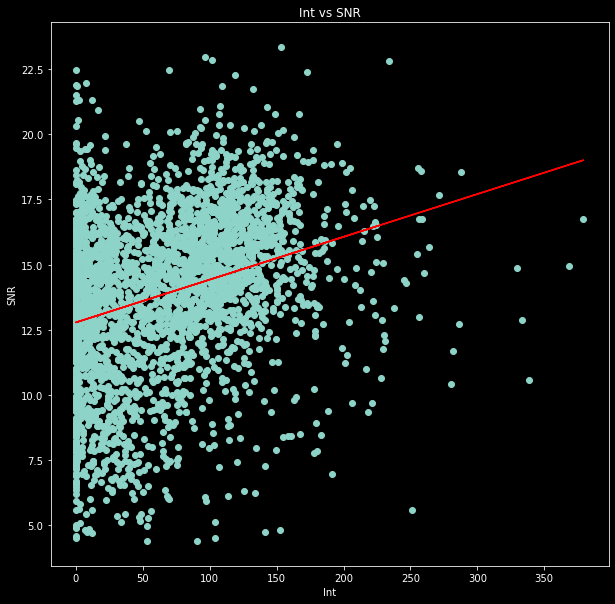

In [12]:
if all_data == True:
    x = df.red_int_mean.values
    y = df.SNR_red.values
else:
    x = df[df['frame'] ==sel_timepoint].red_int_mean.values
    y = df[df['frame'] ==sel_timepoint].SNR_red.values

m, b = np.polyfit(x,y, 1)
print('slope',m)
print('intercept',b)


plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.plot(x, m*x + b,'-r')
plt.title('Int vs SNR')
plt.ylabel('SNR')
plt.xlabel('Int')
plt.show()

# Intensity vs Noise (mean_background_int)

slope 0.40844046628998054
intercept 862.6136643318563


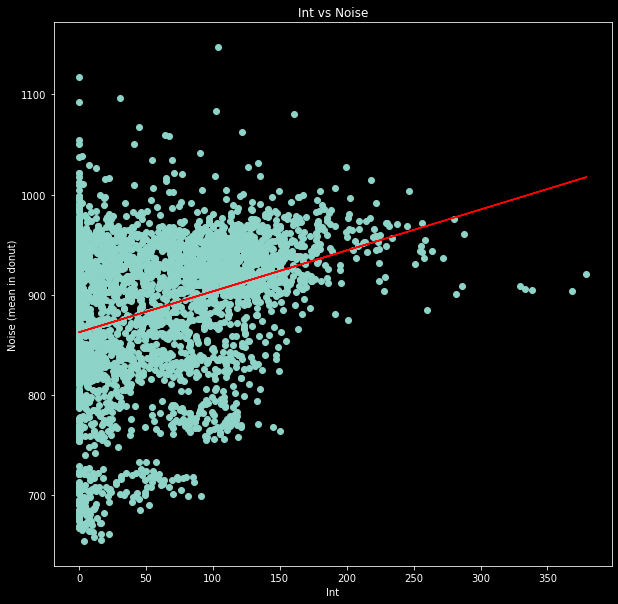

In [13]:
if all_data == True:
    x = df.red_int_mean.values
    y = df.background_int_mean_red.values
else:
    x = df[df['frame'] ==sel_timepoint].red_int_mean.values
    y = df[df['frame'] ==sel_timepoint].background_int_mean_red.values

m, b = np.polyfit(x,y, 1)
print('slope',m)
print('intercept',b)

plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.plot(x, m*x + b,'-r')
plt.title('Int vs Noise')
plt.ylabel('Noise (mean in donut)')
plt.xlabel('Int')
plt.show()

# SNR vs Noise (mean_background_int)

slope -0.007992734165186787
intercept 20.963193531064793


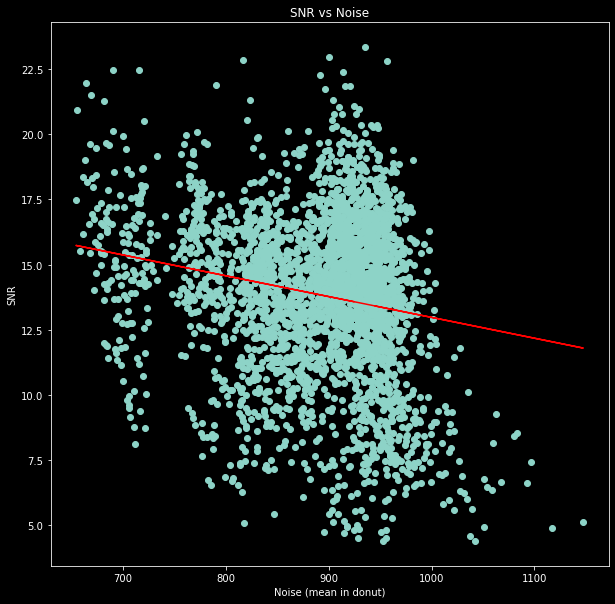

In [14]:
if all_data == True:
    y = df.SNR_red.values
    x = df.background_int_mean_red.values
else:
    y = df[df['frame'] ==sel_timepoint].SNR_red.values
    x = df[df['frame'] ==sel_timepoint].background_int_mean_red.values

m, b = np.polyfit(x,y, 1)
print('slope',m)
print('intercept',b)

plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.plot(x, m*x + b,'-r')
plt.title('SNR vs Noise')
plt.xlabel('Noise (mean in donut)')
plt.ylabel('SNR')
plt.show()

# BG_Int_std vs SNR 

slope -0.11463413230818577
intercept 22.168617832522127


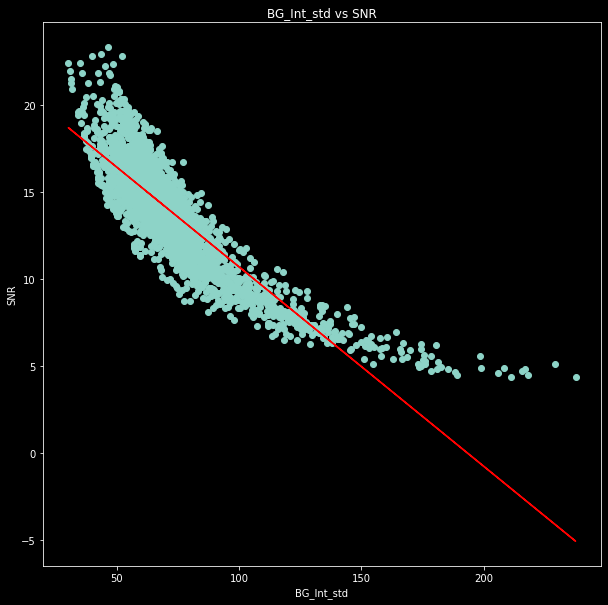

In [15]:
if all_data == True:
    x = df.background_int_std_red.values
    y = df.SNR_red.values
else:
    x = df[df['frame'] ==sel_timepoint].background_int_std_red.values
    y = df[df['frame'] ==sel_timepoint].SNR_red.values

m, b = np.polyfit(x,y, 1)
print('slope',m)
print('intercept',b)

plt.figure(figsize=(10,10))
plt.scatter(x, y)
plt.plot(x, m*x + b,'-r')
plt.title('BG_Int_std vs SNR')
plt.ylabel('SNR')
plt.xlabel('BG_Int_std')
plt.show()

# SNR distribution

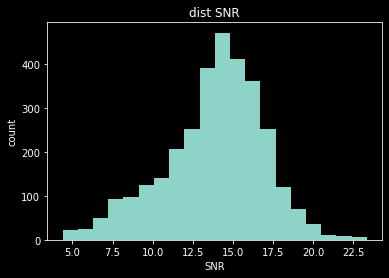

In [16]:
plt.hist(df.SNR_red.values,bins=20)
plt.title('dist SNR')
plt.ylabel('count')
plt.xlabel('SNR')
plt.show()